### Define and train models for title generation

#### Make imports

In [1]:
import torch
import numpy as np
import pickle
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing as skp
from IPython.display import Image

import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
from nltk.translate import bleu_score
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
device = torch.device("cpu")

In [2]:
os.chdir('disk/ERIK_ML/')

In [4]:
X_train = np.load('X_train_padded.npy')
X_test = np.load('X_test_padded.npy')
titles_train_input = np.load('titles_train_input_padded.npy')
titles_train_output = np.load('titles_train_output_padded.npy')
titles_test_input = np.load('titles_test_input_padded.npy')
titles_test_output = np.load('titles_test_output_padded.npy')
embeddings = np.load('embeddings_classification.npy')

In [5]:
f = open('idx2word_titles.pkl','rb')
idx2word_titles = pickle.load(f)
f.close()
NUM_EMBEDDINGS_TITLES = max(list(idx2word_titles.keys()))+1

In [6]:
f = open('word2idx_titles.pkl','rb')
word2idx_titles = pickle.load(f)
f.close()

In [7]:
f = open('word2idx_X.pkl','rb')
word2idx_X = pickle.load(f)

In [8]:
f = open('idx2word_X.pkl','rb')
idx2word_X = pickle.load(f)

In [9]:
N_TRAINING = X_train.shape[0]
N_TESTING = X_test.shape[0]

#### Create tensor dataset

In [10]:
BATCH_SIZE = 32

In [11]:
train_data = TensorDataset(torch.LongTensor(X_train).to(device),
                           torch.LongTensor(titles_train_input).to(device),
                           torch.LongTensor(titles_train_output).to(device))

test_data = TensorDataset(torch.LongTensor(X_test).to(device),
                          torch.LongTensor(titles_test_input).to(device),
                          torch.LongTensor(titles_test_output).to(device))

train_data_loader = DataLoader(train_data, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True)
test_data_loader = DataLoader(test_data, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True)

### Define models

In [12]:
NUM_EMBEDDINGS = embeddings.shape[0]
N_DIM = embeddings.shape[1]
HIDDEN_DIM = 128
MAX_LEN_DECODER = 20
MAX_LEN_ENCODER = X_test.shape[1]

## Seq2Seq with attention

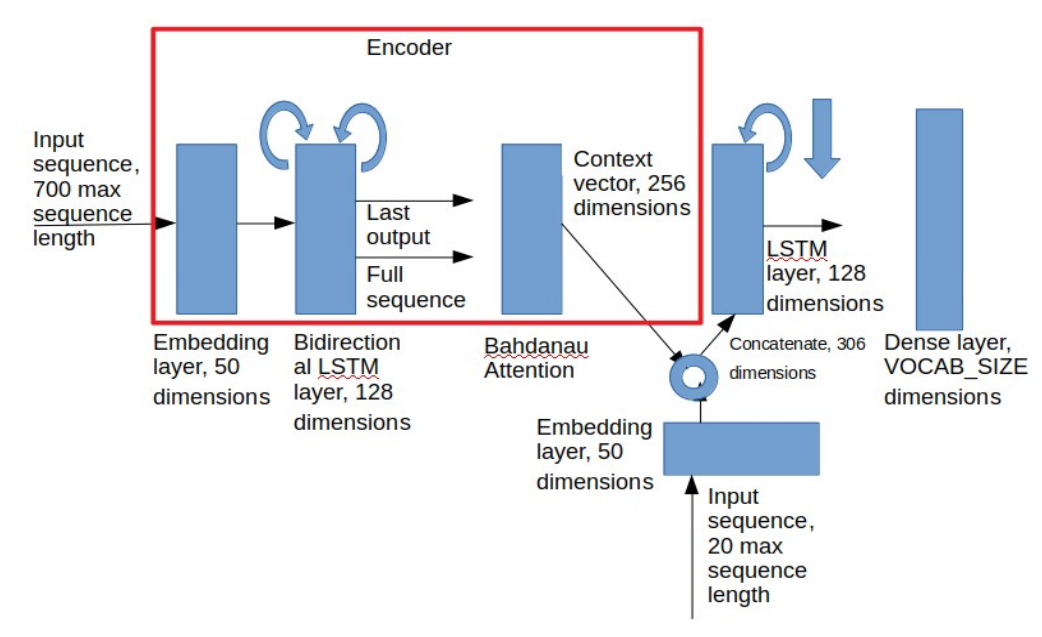

In [3]:
Image(filename = 'generator_model.png')

#### Encoder layer

In [13]:
class Encoder_layer(nn.Module):
    def __init__(self):
        super(Encoder_layer,self).__init__()
        self.embedding = torch.nn.Embedding(NUM_EMBEDDINGS,N_DIM,_weight=torch.Tensor(embeddings).to(device))
        self.lstm = torch.nn.LSTM(N_DIM,HIDDEN_DIM,bidirectional = True,batch_first = True)
    def forward(self, input_):
        input_ = self.embedding(input_)
        #print('embedded size',input_.size())
        full_sequence,b = self.lstm(input_)
        #print('lstm sequences size',output.size()) [BATCH, SEQ_LEN, 256]
        #print('lstm sequences last',output[0,0,128:])
        #print('hidden state size : {}, cell state size : {}'.format(b[0].size(),b[1].size()))
        #print('hidden state size : {}'.format(b[0][1,0]))
        #print('series through linear : ',output.size())
        #print(b[0].size()) [N_DIRECTIONS, BATCH, N_DIMS]
        # concatenate the hidden states to use them later 
        last_hidden_state = torch.cat([b[0][0],b[0][1]],dim = -1)
        #print(last_hidden_state.size()) # torch.Size([BATCH, 256])
        return full_sequence, last_hidden_state
    

#### Attention layer

In [14]:
class Attention_layer(nn.Module):
    def __init__(self):
        super(Attention_layer,self).__init__()
        self.sequence_transformer = nn.Linear(HIDDEN_DIM*2,HIDDEN_DIM)
        self.last_state_transformer = nn.Linear(HIDDEN_DIM*2,HIDDEN_DIM)
        self.dimension_reducer = nn.Linear(HIDDEN_DIM,1)
    def forward(self, last_state, sequence):
        last_state = last_state.view(last_state.size()[0],
                                1,
                                last_state.size()[1])
        #print('new last state size: ',last_state.size()) # torch.Size([BATCH, 1, 512])
        seq_logits = self.dimension_reducer(
                    torch.tanh(
                    self.sequence_transformer(sequence) + 
                    self.last_state_transformer(last_state)
                    )
        )
        #print(seq_logits.size()) # ([BACH, SEQ_LEN, 1])
        attention_weights = F.softmax(seq_logits,dim = 1)
        #print(attention_weights.size()) # torch.Size([BATCH, SEQ_LEN, 1])
        
        context_vector = attention_weights*sequence
        #print(context_vector.size()) # [BATCH, SEQ_LEN, HIDDEN_DIM*2]
        context_vector = torch.sum(context_vector,dim = 1)
        #print(context_vector.size()) # [BATCH, HIDDEN_DIM*2]
        return context_vector, attention_weights

#### Decoder

In [15]:
class Decoder_layer(nn.Module):
    def __init__(self):
        super(Decoder_layer,self).__init__()
        self.embedding = nn.Embedding(NUM_EMBEDDINGS_TITLES,N_DIM)
        self.lstm = torch.nn.LSTM(N_DIM + 2*HIDDEN_DIM,HIDDEN_DIM*2,bidirectional = False,batch_first = True)
        self.linear = nn.Linear(HIDDEN_DIM*2,NUM_EMBEDDINGS_TITLES)
    def forward(self,input_, context, hidden_state, cell_state):#last_states):
        """
        input_ [BATCH, 1]: sequence of word frequences [0...LEN_DICTIONARY]
        context [BATCH, 2*HIDDEN_DIM]: the computed context vector (Attention Layer) [B,2*HIDDEN_DIM]
        hidden_state : the last possible hidden state of the decoder
        cell_state : the last possible cell state of the decoder
        """
        '''
        hidden_state = last_states[0]
        cell_state = last_states[1]'''
        input_ = self.embedding(input_) 
        #print('after embedding',input_.size()) #[BATCH, SEQ_LEN = 1 , N_DIM]
        #print(context.unsqueeze(1).size()) #[BATCH, SEQ_LEN = 1, 256] 
        input_ = torch.cat([input_,context.unsqueeze(1)],dim = -1)
        #print('after concatenation ',input_.size()) # [BATCH, SEQ_LEN = 1, 306]
        #print(hidden_state.size()) # [DIRECTIONS, BATCH , 256]
         
        output, states = self.lstm(input_, (hidden_state, cell_state))

        #print('after lstm ',output.size())[BATCH, SEQ_LEN, HIDDEN_DIM]
       
        output = self.linear(output)
        #print('final output ',output.size()) [BATCH, SEQ_LEN, LEN_DICTIONARY]
        hidden_state = states[0]
        #print(hidden_state.size()) #[DIRECTIONS, BATCH, 256]
        cell_state = states[1]
        #print(cell_state.size()) [DIRECTIONS, BATCH, 256]
        return output, hidden_state, cell_state

#### Seq2Seq with attention

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder_layer()
        self.attention = Attention_layer()
        self.decoder = Decoder_layer()
    def forward(self, encoder_input, decoder_input, teacher_forcing = True):
        
        #print('input size',encoder_input.size())
        full_sequence, last_hidden_state = self.encoder(encoder_input)
        #print('full sequence size: ',full_sequence.size())
        #print('last hidden state size : ',last_hidden_state.size())
        
        context_vector, attention_weights = self.attention(
                                        last_hidden_state,
                                        full_sequence
                                        )
        #print('context vector size: ',context_vector.size())
        #print('attention weights size: ', attention_weights.size()) [BATCH, SEQ_LEN, 1]
        
        all_attention_weights = torch.zeros(MAX_LEN_DECODER,
                                            attention_weights.size()[0],
                                            MAX_LEN_ENCODER,1
                                            ).to(device)
        #print(all_attention_weights.size()) [DEC_ML, BATCH, SEQ_LEN, 1]
        all_attention_weights[0] = attention_weights
        
        output = self.decode(decoder_input,
                                           full_sequence,
                                           context_vector,
                                           last_hidden_state,
                                           teacher_forcing,
                                           all_attention_weights)

        
        return output, all_attention_weights
            
    def decode(self,
                             decoder_input,
                             full_sequence,
                             context_vector,
                             last_hidden_state, 
                             teacher_forcing,
                             all_attention_weights):
        #print('initial input size: ',decoder_input[:,0].unsqueeze(1).size()) [BATCH, SEQUENCE]
        output, hidden_state, cell_state = self.decoder(
                                            decoder_input[:,0].unsqueeze(1),
                                            context_vector,
                                            last_hidden_state.unsqueeze(0),
                                            torch.zeros_like(last_hidden_state).unsqueeze(0).to(device)
                                                       )
        output_new = output
        for i in range(1,MAX_LEN_DECODER):
            if teacher_forcing:
                next_ = decoder_input[:,i].unsqueeze(1)
            else:
                # get the most probable word
                next_ = torch.argmax(output_new,dim = -1)
                #print('next_ size :',next_.size()) # [BATCH, 1]
            context_vector, attention_weights = self.attention(
                                        hidden_state.squeeze(),
                                        full_sequence
                                        )
            output_new, hidden_state, cell_state = self.decoder(
                                            next_,
                                            context_vector,
                                            hidden_state,
                                            cell_state
                                                       )
            #print(output_new.size()) [BATCH, 1, LEN_DICT]
            
            output = torch.cat([output,output_new],dim = 1)
            all_attention_weights[i] = attention_weights
            
        return output
        

#### Define training function

In [17]:
def train(model, loss, optimizer):
    training_loss = []
    test_loss = []
    for epoch in range(1,EPOCHS+1):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        # loop over the training data
        for X,input_,y in tqdm_notebook(train_data_loader):
            optimizer.zero_grad()
            logits, _ = model(X,input_,True)
            predictions = torch.argmax(logits,dim = -1)
            print(predictions.size())
            break
            # transform the tensors in order to make cross entropy
            # calculation possible : logits [BATCH*SEQ_LEN x VOCAB] 
            # y [BATCH*SEQ_LEN]
            cost = loss(logits.view(logits.size()[0]*logits.size()[1],NUM_EMBEDDINGS_TITLES),
                        y.view(y.size()[0]*y.size()[1]))
            cost.backward()
            
            optimizer.step()
            epoch_loss+=cost.item()
        print('Training loss in the {}. epoch: '.format(epoch),epoch_loss/1329)
        training_loss.append(epoch_loss/1329)
        

In [18]:
def eval_(model):
    all_texts = []
    all_predictions = []
    all_targets = []
    all_attention_weights = []
    with torch.no_grad():
        for X,input_,y in tqdm_notebook(test_data_loader):
            logits, attention_weights = model(X,input_,False)
            predictions = torch.argmax(logits,dim = -1)
            all_predictions.append(predictions)
            all_texts.append(X)
            all_targets.append(y)
            all_attention_weights.append(attention_weights)
            
            # transform the tensors in order to make cross entropy
            # calculation possible : logits [BATCH*SEQ_LEN x VOCAB] 
            # y [BATCH*SEQ_LEN]
    return all_predictions, all_texts, all_targets, all_attention_weights

In [19]:
model = Seq2Seq()

In [20]:
model.load_state_dict(torch.load('generator/model_at_130_iteration'))

In [21]:
all_predictions, all_texts, all_targets, all_weights = eval_(model)

In [24]:
# to texts
texts = []
i = 0
for x in all_texts:
    for text in x:
        texts.append([])
        for word in text:
        
            word = idx2word_X.get(word.item())
            
            if word != None:
                   
                texts[i].append(word)
        i+=1

In [19]:
def to_list(tensor_list):
    all_preds = []
    for y in tensor_list:
        for y_ in y:
            sentence = []
            for i in y_:

                word = idx2word_titles.get(i.item())
                if word != None:
                    if word == 'stop':
                        break
                    else:
                        sentence.append(word)
            all_preds.append(sentence)
    return all_preds

In [73]:
all_preds  = to_list(all_predictions)

15000

In [ ]:
all_originals = to_list(all_targets)

In [132]:
all_preds[1310]

['hausverkauf', 'wer', 'haftet', 'für', 'kredit', 'grundschuld']

In [89]:
bleu_scores = [0.0]*4
for y, pred in zip(all_originals,all_preds):
    bleu_scores[0] += bleu_score.sentence_bleu([y],pred,(1.0,0.0,0.0,0.0)) # BLEU - 1
    bleu_scores[1] += bleu_score.sentence_bleu([y],pred,(0.5,0.5,0.0,0.0))
    bleu_scores[2] += bleu_score.sentence_bleu([y],pred,(0.33,0.33,0.33,0.0))
    bleu_scores[3] += bleu_score.sentence_bleu([y],pred,(0.25,0.25,0.25,0.25))

/home/ek/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ek/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ek/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunctio

In [92]:
bleu_scores[2]/len(all_preds)

0.15513220212026252

In [91]:
bleu_scores[1]/len(all_preds)

0.18208950336285804

In [94]:
bleu_scores[0]/len(all_preds)

0.23613248720994706

In [96]:
bleu_scores[3]/len(all_preds)

0.11875126086649754

In [23]:
print(NUM_EMBEDDINGS_TITLES)

43923
